In [28]:
import shap
import xgboost

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

from sklearn.base import clone

import numpy as np
import bench
import glob

import hypotactic
import bench

import unicodedata
import string
import udpipe2

from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

In [2]:
import mpl_fontkit as fk

# https://fonts.google.com/specimen/Lato?query=Lato
fk.install("Roboto Slab")
fk.set_font("Roboto Slab")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (3, 3)

Font name: `Roboto Slab`


1. Import corpus
- Single heroides, even doubles
- Ars Amatoria, odd doubles

In [3]:
collection = []
for fn in sorted(glob.glob("corpus/heroides*.html")):
    try:
        collection.append(hypotactic.extract_file(fn))
    except Exception as e:
        print(f"Failed on {fn}")
        raise e
for fn in sorted(glob.glob("corpus/ars*.html")):
    try:
        collection.append(hypotactic.extract_file(fn))
    except Exception as e:
        print(f"Failed on {fn}")
        raise e

In [7]:
ovid_df = pd.concat(collection).reset_index(drop=True)
ovid_df.insert(0, "canonical_title", ovid_df.apply(hypotactic.canonical_title, axis=1))
ovid_df

,canonical_title,author,work,meter,book,number,title,lines,text
0,Heroides 1,Ovid,Heroides,elegy,1,,Penelope Ulixi,116,"Haec tua Pēnelope lentō tibi mittit, Ulixe\nnī..."
1,Heroides 10,Ovid,Heroides,elegy,10,,,152,"Illa relicta ferīs etiam nunc, improbe Thēseu\..."
2,Heroides 11,Ovid,Heroides,elegy,11,,,130,Aeolis Aeolidae quam nōn habet ipsa salūtem\nm...
3,Heroides 12,Ovid,Heroides,elegy,12,,,214,"Exul inops comtempta novō Mēdēa marītō\ndīcit,..."
4,Heroides 13,Ovid,Heroides,elegy,13,,,164,"Mittit et optat amāns, quō mittitur, īre salūt..."
5,Heroides 14,Ovid,Heroides,elegy,14,,,132,Mittit Hypermestrā dē tot modo frātribus ūnī;\...
6,Heroides 15,Ovid,Heroides,elegy,15,,,220,"Ecquid, ut adspecta est studiōsae littera dext..."
7,Heroides 16,Ovid,Heroides,elegy,16,,,378,"Hanc tibi Prīamidēs mittō, Lēdaea, salūtem,\nq..."
8,Heroides 17,Ovid,Heroides,elegy,17,,,270,"Sī mihi quae lēgī, Pari, nōn lēgisse licēret,\..."
9,Heroides 18,Ovid,Heroides,elegy,18,,,220,"Quam cuperem solitās, Hērō, tibi ferre per und..."


In [8]:
ovid_df = ovid_df[ovid_df["author"] == "Ovid"]
ovid_df = ovid_df[["canonical_title", "work", "text"]]
ovid_df

,canonical_title,work,text
0,Heroides 1,Heroides,"Haec tua Pēnelope lentō tibi mittit, Ulixe\nnī..."
1,Heroides 10,Heroides,"Illa relicta ferīs etiam nunc, improbe Thēseu\..."
2,Heroides 11,Heroides,Aeolis Aeolidae quam nōn habet ipsa salūtem\nm...
3,Heroides 12,Heroides,"Exul inops comtempta novō Mēdēa marītō\ndīcit,..."
4,Heroides 13,Heroides,"Mittit et optat amāns, quō mittitur, īre salūt..."
5,Heroides 14,Heroides,Mittit Hypermestrā dē tot modo frātribus ūnī;\...
6,Heroides 15,Heroides,"Ecquid, ut adspecta est studiōsae littera dext..."
7,Heroides 16,Heroides,"Hanc tibi Prīamidēs mittō, Lēdaea, salūtem,\nq..."
8,Heroides 17,Heroides,"Sī mihi quae lēgī, Pari, nōn lēgisse licēret,\..."
9,Heroides 18,Heroides,"Quam cuperem solitās, Hērō, tibi ferre per und..."


In [9]:
# remove macrons from Latin text
def remove_macrons(text: str) -> str:
    return unicodedata.normalize("NFD", text).replace("\u0304", "")


def remove_punctuation(text):
    """Remove standard punctuation using translate"""
    return text.translate(str.maketrans("", "", string.punctuation))


def lemmaproc(s: str, pos: str) -> str:
    if pos in ["PROPN", "NUM"]:
        return pos
    return remove_punctuation(s).lower()


def parse_mask_udpipe(s: str, client: udpipe2.UDPipeClient) -> pd.DataFrame:
    """
    Given a string s (a complete poem or book) and a udpipe2.UDPipeClient instance, return a
    DataFrame with columns 'text', 'masked', 'POS', and 'feats'. Words with POS in the masklist are
    replaced by their POS tag in the 'masked' column.

    Inputs:
        - s: the original string
        - client: the udpipe2.UDPipeClient instance

    Returns:
        - A DataFrame with the processed information.
    """
    final = []
    s = remove_macrons(s)
    resp = client.process_string(s, raw=False)
    lines = s.split("\n")
    this_line = lines.pop(0).split(" ")
    this_word = ""
    masklist = ["PROPN", "NOUN", "ADJ", "VERB", "NUM"]
    for f in resp[0]:
        f_idx = 0
        this = {"text": [], "masked": [], "POS": [], "feats": [], "lemmata": []}
        while f_idx < f.shape[0]:
            row = f.iloc[f_idx]
            try:
                last_word = this_word
                this_word = this_line.pop(0)
            except IndexError:
                this_line = lines.pop(0).split(" ")
                this_word = this_line.pop(0)
            # the huge bulk of mismatches are from enclitic "que"
            if row.word == "que" and row.POS == "CCONJ" and not this_word == "que":
                # special case for enclitic que
                # if this is triggered at the end of the line, we need to insert before the <EOL>
                if this["POS"][-1] == "<EOL>":
                    this["POS"].insert(-1, row.POS)
                    this["lemmata"].insert(-1, lemmaproc(row.lemma, row.POS))
                    this["masked"].insert(-1, remove_punctuation(row.word).lower())
                else:
                    this["POS"].append(row.POS)
                    this["lemmata"].append(lemmaproc(row.lemma, row.POS))
                    this["masked"].append(remove_punctuation(row.word).lower())
                # the que would mismatch below (the dataframe has one extra row), but this line word
                # should match the _next_ row word, so un-pop it.
                this_line.insert(0, this_word)
                f_idx += 1
                continue
            # POTENTIAL BUG: If  there are two words in a row with an enclictic that is not -que
            # this will be buggy.
            if not row.word in this_word:
                if row.word in last_word:
                    if this["POS"][-1] == "<EOL>":
                        this["POS"].insert(-1, row.POS)
                        this["lemmata"].insert(-1, lemmaproc(row.lemma, row.POS))
                        this["masked"].insert(-1, remove_punctuation(row.word).lower())
                    else:
                        this["POS"].append(row.POS)
                        this["lemmata"].append(lemmaproc(row.lemma, row.POS))
                        this["masked"].append(remove_punctuation(row.word).lower())
                    this_line.insert(0, this_word)
                    f_idx += 1
                    continue
                print(
                    f"this_word: {this_word} last_word: {last_word} row.word: {row.word}"
                )
                print(" ".join(f.word))
                raise ValueError(
                    f"Unrecoverable mismatch: '{this_word}' vs '{row.word}' at frame index {f_idx}"
                )
            this["text"].append(this_word)
            this["POS"].append(row.POS)
            this["lemmata"].append(lemmaproc(row.lemma, row.POS))
            this["feats"].extend(row.Feats.split("|"))
            if row.POS in masklist:
                this["masked"].append(row.POS)
            else:
                this["masked"].append(remove_punctuation(row.word).lower())
            if len(this_line) == 0:
                this["POS"].append("<EOL>")
                this["lemmata"].append("<EOL>")
                this["text"][-1] += "\n"
                this["masked"].append("<EOL>")
            f_idx += 1
        this["POS"].append("<EOS>")
        this["lemmata"].append("<EOS>")
        this["masked"].append("<EOS>")
        final.append(this)
    df = pd.DataFrame([{k: " ".join(v) for k, v in row.items()} for row in final])
    df["feats"] = df["feats"].str.replace("_ ", "")
    return df

In [10]:
client_eva24 = udpipe2.UDPipeClient(
    {
        "model": "latin-evalatin24-240520",
        "input": "generic_tokenizer",
        "tokenizer": "normalized_spaces",
        "parser": "",
        "tagger": "",
    }
)

In [11]:
def parsefunc(row):
    df = parse_mask_udpipe(row["text"], client_eva24)
    df.insert(
        0, "sentence", df.apply(lambda x: f"{row.canonical_title}-{x.name}", axis=1)
    )
    print(f"Parsed {row.canonical_title} with {df.shape[0]} sentences")
    return df


dfs = [parsefunc(row) for _, row in ovid_df.iterrows()]

Parsed Heroides 1 with 71 sentences
Parsed Heroides 10 with 112 sentences
Parsed Heroides 11 with 87 sentences
Parsed Heroides 12 with 131 sentences
Parsed Heroides 13 with 103 sentences
Parsed Heroides 14 with 99 sentences
Parsed Heroides 15 with 142 sentences
Parsed Heroides 16 with 228 sentences
Parsed Heroides 17 with 189 sentences
Parsed Heroides 18 with 134 sentences
Parsed Heroides 19 with 124 sentences
Parsed Heroides 2 with 91 sentences
Parsed Heroides 20 with 180 sentences
Parsed Heroides 21 with 148 sentences
Parsed Heroides 3 with 100 sentences
Parsed Heroides 4 with 116 sentences
Parsed Heroides 5 with 115 sentences
Parsed Heroides 6 with 106 sentences
Parsed Heroides 7 with 130 sentences
Parsed Heroides 8 with 89 sentences
Parsed Heroides 9 with 93 sentences
Parsed Ars Amatoria 1 with 417 sentences
Parsed Ars Amatoria 2 with 407 sentences
Parsed Ars Amatoria 3 with 439 sentences


In [12]:
bigdf = pd.concat(dfs, ignore_index=True)
bigdf

,sentence,text,masked,POS,feats,lemmata
0,Heroides 1-0,"Haec tua Penelope lento tibi mittit, Ulixe\n n...",haec tua PROPN ADJ tibi VERB PROPN <EOL> nil m...,DET DET PROPN ADJ PRON VERB PROPN <EOL> PRON P...,Case=Acc Gender=Neut Number=Plur PronType=Dem ...,hic tuus PROPN lentus tu mitto PROPN <EOL> nih...
1,Heroides 1-1,"Troja jacet certe, Danais invisa puellis;\n",PROPN VERB certe ADJ ADJ NOUN <EOL> <EOS>,PROPN VERB ADV ADJ ADJ NOUN <EOL> <EOS>,Case=Nom Gender=Fem Number=Sing Aspect=Imp Moo...,PROPN jaceo certe danaus invisus puella <EOL> ...
2,Heroides 1-2,vix Priamus tanti totaque Troja fuit.\n,vix PROPN tanti tota que PROPN fuit <EOL> <EOS>,ADV PROPN DET DET CCONJ PROPN AUX <EOL> <EOS>,Case=Nom Gender=Masc Number=Sing Case=Gen Gend...,vix PROPN tantus totus que PROPN sum <EOL> <EOS>
3,Heroides 1-3,"o utinam tum, cum Lacedaemona classe petebat,\...",o utinam tum cum ADJ NOUN VERB <EOL> VERB ADJ ...,PART ADV ADV SCONJ ADJ NOUN VERB <EOL> VERB AD...,AdvType=Tim Case=Acc Gender=Neut Number=Plur C...,o utinam tum cum lacedaemonus classis peto <EO...
4,Heroides 1-4,"non ego deserto jacuissem frigida lecto,\n nec...",non ego VERB VERB ADJ NOUN <EOL> nec VERB ADJ ...,PART PRON VERB VERB ADJ NOUN <EOL> CCONJ VERB ...,Case=Nom Number=Sing Person=1 PronType=Prs Asp...,non ego deserto jaceo frigidus lectus <EOL> ne...
...,...,...,...,...,...,...
3846,Ars Amatoria 3-434,"Gaudia post Veneris quae poscet munus amantem,...",NOUN post PROPN quae VERB NOUN VERB <EOL> illa...,NOUN ADP PROPN PRON VERB NOUN VERB <EOL> DET D...,Case=Acc Gender=Neut Number=Plur Case=Gen Gend...,gaudium post PROPN qui posco munus amo <EOL> i...
3847,Ars Amatoria 3-435,Nec lucem in thalamos totis admitte fenestris;\n,nec NOUN in NOUN totis VERB NOUN <EOL> <EOS>,CCONJ NOUN ADP NOUN DET VERB NOUN <EOL> <EOS>,Case=Acc Gender=Fem Number=Sing Case=Acc Gende...,neque lux in thalamus totus admitto fenestra <...
3848,Ars Amatoria 3-436,Aptius in vestro corpore multa latent.\n,aptius in vestro NOUN multa VERB <EOL> <EOS>,ADV ADP DET NOUN DET VERB <EOL> <EOS>,Degree=Cmp Case=Abl Gender=Masc Number=Sing Nu...,apte in vester corpus multus lateo <EOL> <EOS>
3849,Ars Amatoria 3-437,"Lusus habet finem: cygnis descendere tempus,\n...",NOUN VERB NOUN NOUN VERB NOUN <EOL> VERB NOUN ...,NOUN VERB NOUN NOUN VERB NOUN <EOL> VERB NOUN ...,Case=Nom Gender=Masc Number=Sing Aspect=Imp In...,lusus habeo finis cygnus descendo tempus <EOL>...


In [13]:
# take the sentence column and keep everything up to the hyphen
bigdf.insert(0, "title", bigdf.sentence.str.split("-").str[0])

In [14]:
bigdf.iloc[0].text

'Haec tua Penelope lento tibi mittit, Ulixe\n nil mihi rescribas attinet: ipse veni!\n'

In [15]:
heroides_f = bigdf[
    (bigdf["title"].str.contains("Heroides"))
    & (bigdf["title"].str.extract(r"Heroides\s+(\d+)", expand=False).astype(float) < 16)
]
heroides_f.insert(1, "speaker", "female")
heroides_f.shape

(1585, 8)

In [16]:
ars_amatoria = bigdf[bigdf["title"].str.contains("Ars Amatoria")]
ars_amatoria.insert(1, "speaker", "male")
ars_amatoria.shape

(1263, 8)

In [17]:
train_df = pd.concat([heroides_f, ars_amatoria]).reset_index(drop=True)
train_df.speaker.value_counts()

speaker
female    1585
male      1263
Name: count, dtype: int64

In [18]:
bench_m = bigdf[
    (bigdf["title"].str.contains("Heroides"))
    & (
        bigdf["title"].str.extract(r"Heroides\s+(\d+)", expand=False).astype(float)
        >= 16
    )
    & (
        bigdf["title"].str.extract(r"Heroides\s+(\d+)", expand=False).astype(float) % 2
        == 0
    )
]
bench_m.title.value_counts()
bench_m.insert(1, "speaker", "male")

In [19]:
bench_f = bigdf[
    (bigdf["title"].str.contains("Heroides"))
    & (
        bigdf["title"].str.extract(r"Heroides\s+(\d+)", expand=False).astype(float)
        >= 16
    )
    & (
        bigdf["title"].str.extract(r"Heroides\s+(\d+)", expand=False).astype(float) % 2
        == 1
    )
]
bench_f.title.value_counts()
bench_f.insert(1, "speaker", "female")

In [20]:
eval_df = pd.concat([bench_f, bench_m]).reset_index(drop=True)
eval_df.speaker.value_counts()

speaker
male      542
female    461
Name: count, dtype: int64

In [21]:
# remove characters from the features that cause problems
train_df["feats"] = train_df.feats.replace(r"\[", "(", regex=True)
train_df["feats"] = train_df.feats.replace(r"\]", ")", regex=True)
train_df["masked"] = train_df.masked.replace(r"\<", "(", regex=True)
train_df["masked"] = train_df.masked.replace(r"\>", ")", regex=True)
train_df["lemmata"] = train_df.lemmata.replace(r"\<", "(", regex=True)
train_df["lemmata"] = train_df.lemmata.replace(r"\>", ")", regex=True)
# inflection class becomes a thin proxy for lexis, so remove it
train_df["feats"] = train_df.feats.replace("InflClass.*? ", "", regex=True)
# Imperfective aspect also gets applied to infinitives which makes it not very useful
train_df["feats"] = train_df["feats"].replace("Aspect=Imp ", "", regex=True)
eval_df["feats"] = eval_df.feats.replace(r"\[", "(", regex=True)
eval_df["feats"] = eval_df.feats.replace(r"\]", ")", regex=True)
eval_df["masked"] = eval_df.masked.replace(r"\<", "(", regex=True)
eval_df["masked"] = eval_df.masked.replace(r"\>", ")", regex=True)
train_df["lemmata"] = train_df.lemmata.replace(r"\<", "(", regex=True)
train_df["lemmata"] = train_df.lemmata.replace(r"\>", ")", regex=True)
eval_df["lemmata"] = eval_df.lemmata.replace(r"\<", "(", regex=True)
eval_df["lemmata"] = eval_df.lemmata.replace(r"\>", ")", regex=True)
eval_df["feats"] = eval_df.feats.replace("InflClass.*? ", "", regex=True)
eval_df["feats"] = eval_df["feats"].replace("Aspect=Imp ", "", regex=True)

In [22]:
train_df[train_df.speaker == "male"].text.str.count(" ").describe()

count    1263.000000
mean       10.794141
std         6.447058
min         0.000000
25%         6.000000
50%        11.000000
75%        12.000000
max        49.000000
Name: text, dtype: float64

In [23]:
train_df[train_df.speaker == "female"].text.str.count(" ").describe()

count    1585.000000
mean        8.781073
std         6.097329
min         0.000000
25%         5.000000
50%         7.000000
75%        12.000000
max        54.000000
Name: text, dtype: float64

In [24]:
eval_df[eval_df.speaker == "male"].text.str.count(" ").describe()

count    542.000000
mean       9.236162
std        5.342566
min        0.000000
25%        5.000000
50%       10.000000
75%       12.000000
max       49.000000
Name: text, dtype: float64

In [25]:
eval_df[eval_df.speaker == "female"].text.str.count(" ").describe()

count    461.000000
mean       9.485900
std        5.874625
min        0.000000
25%        5.000000
50%        9.000000
75%       12.000000
max       44.000000
Name: text, dtype: float64

In [29]:
bitri = make_pipeline(
    CountVectorizer(
        lowercase=False,
        analyzer="word",
        tokenizer=lambda x: x.split(" "),
        token_pattern=None,
        ngram_range=(2, 3),
        max_features=1000,
    ),
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
)
bitri.fit(pd.concat([eval_df["masked"], train_df["masked"]]))

unigrams = make_pipeline(
    CountVectorizer(
        lowercase=False,
        analyzer="word",
        tokenizer=lambda x: x.split(" "),
        token_pattern=None,
    ),
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
)
unigrams.fit(pd.concat([eval_df["feats"], train_df["feats"]]))


def maskvec(
    df: pd.DataFrame,
    groups: list[str],
    start_col: int = 4,
    squish=1,
    scale=True,
    norm=True,
) -> pd.DataFrame:
    """
    Generate a combined DataFrame by scaling and normalizing specific groups of features.

    This function processes a DataFrame by applying scaling and normalization to
    different feature groups ('rawtree', 'signed_tree', and 'feats') and then combines
    the processed groups into a single DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing raw data to be processed.
        squish (int, optional): A parameter to control the squishing factor during scaling. Defaults to 1.
        scale (bool, optional): Whether to apply scaling to the feature groups. Defaults to True.
        norm (bool, optional): Whether to apply normalization to the feature groups. Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing the combined and processed feature groups.
    """
    posunibi = bench.df_scale_group(
        df,
        bitri,
        "masked",
        groups=groups,
        start_col=start_col,
        squish=squish,
        scale=scale,
        norm=norm,
        fit=False,
    )
    feats = bench.df_scale_group(
        df,
        unigrams,
        "feats",
        groups=groups,
        start_col=start_col,
        squish=squish,
        scale=scale,
        norm=norm,
        fit=False,
    ).iloc[:, start_col + 1 :]
    combined = pd.concat([posunibi, feats], axis=1)
    return combined

In [30]:
unibi = make_pipeline(
    CountVectorizer(
        lowercase=False,
        analyzer="word",
        tokenizer=lambda x: x.split(" "),
        token_pattern=None,
        ngram_range=(1, 2),
        max_features=5000,
    ),
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
)
unibi.fit(pd.concat([eval_df["lemmata"], train_df["lemmata"]]))


def lemmavec(
    df: pd.DataFrame,
    groups: list[str],
    start_col: int = 4,
    squish=1,
    scale=True,
    norm=True,
) -> pd.DataFrame:
    """

    Args:
        df (pd.DataFrame): The input DataFrame containing raw data to be processed.
        squish (int, optional): A parameter to control the squishing factor during scaling. Defaults to 1.
        scale (bool, optional): Whether to apply scaling to the feature groups. Defaults to True.
        norm (bool, optional): Whether to apply normalization to the feature groups. Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing the combined and processed feature groups.
    """
    lemmataunibi = bench.df_scale_group(
        df,
        unibi,
        "lemmata",
        groups=groups,
        start_col=start_col,
        squish=squish,
        scale=scale,
        norm=norm,
        fit=False,
    )

    return lemmataunibi

2. Syntax benchmark

In [31]:
xgb = xgboost.XGBClassifier(
    learning_rate=0.2,
    n_estimators=150,
    max_depth=8,
    min_child_weight=1,
    gamma=0,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    colsample_bynode=0.5,
    objective="binary:logistic",
    eval_metric="logloss",
    nthread=10,
    scale_pos_weight=1,
    seed=42,
)

In [ ]:
# train_df.to_csv("ovid_voice_train.csv", index=False)
# eval_df.to_csv("ovid_voice_eval.csv", index=False)

Average Classification Report (25 splits with test size 0.1):
male                      precision 68.1%  recall 64.2%  f1-score 66.0%  support 126
female                    precision 72.8%  recall 76.0%  f1-score 74.4%  support 159
accuracy                  70.8%
macro avg_precision       70.5%
macro avg_recall          70.1%
macro avg_f1-score        70.2%
macro avg_support         285
weighted avg_precision    70.7%
weighted avg_recall       70.8%
weighted avg_f1-score     70.7%
weighted avg_support      285


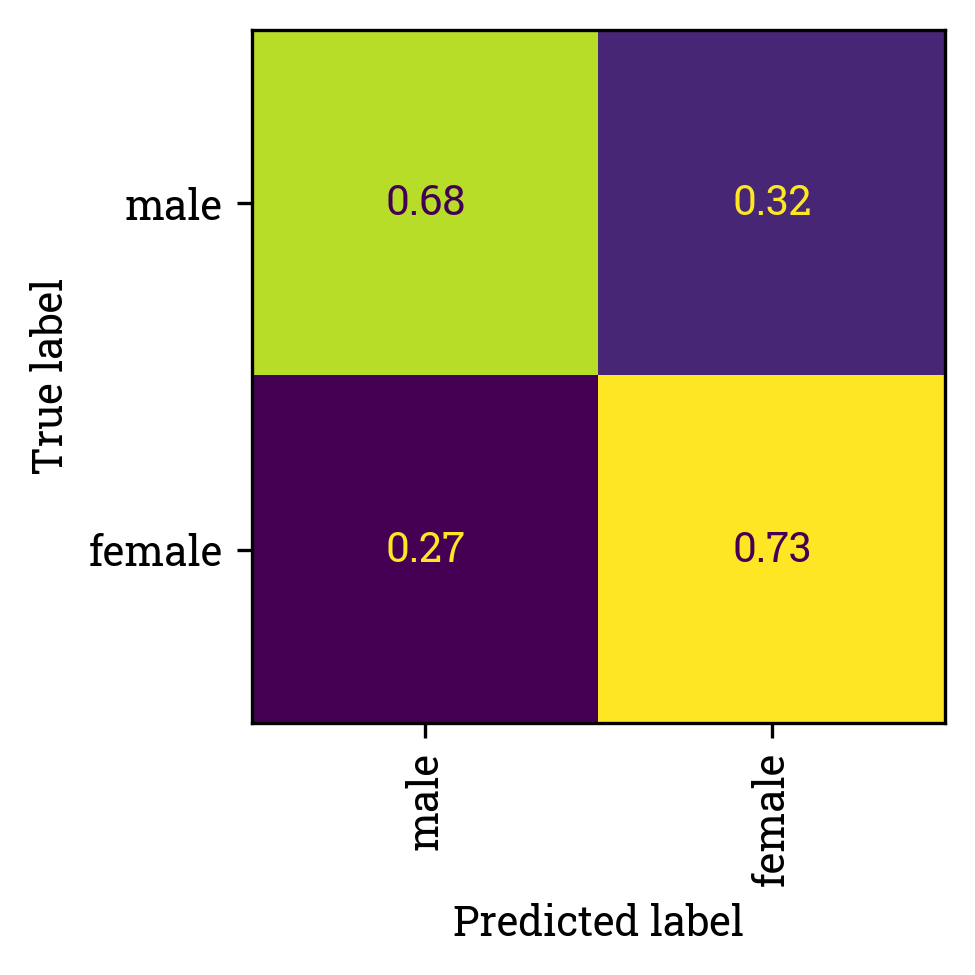

Squish 1: Macro F1-Score: 70.2%

Average Classification Report (25 splits with test size 0.1):
male                      precision 73.0%  recall 70.0%  f1-score 71.4%  support 63
female                    precision 77.2%  recall 79.6%  f1-score 78.3%  support 80
accuracy                  75.3%
macro avg_precision       75.1%
macro avg_recall          74.8%
macro avg_f1-score        74.8%
macro avg_support         143
weighted avg_precision    75.3%
weighted avg_recall       75.3%
weighted avg_f1-score     75.2%
weighted avg_support      143


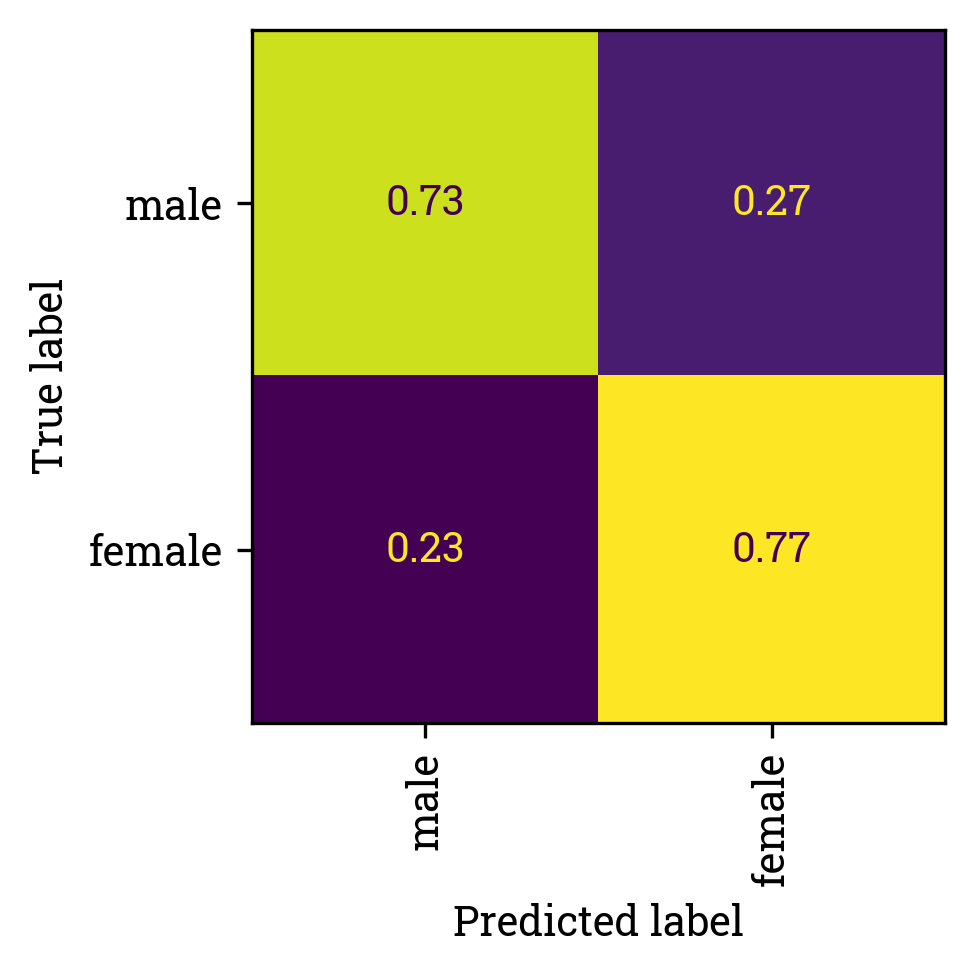

Squish 2: Macro F1-Score: 74.8%

Average Classification Report (25 splits with test size 0.1):
male                      precision 79.7%  recall 78.9%  f1-score 79.0%  support 25
female                    precision 84.2%  recall 84.4%  f1-score 84.2%  support 33
accuracy                  82.0%
macro avg_precision       81.9%
macro avg_recall          81.6%
macro avg_f1-score        81.6%
macro avg_support         58
weighted avg_precision    82.3%
weighted avg_recall       82.0%
weighted avg_f1-score     82.0%
weighted avg_support      58


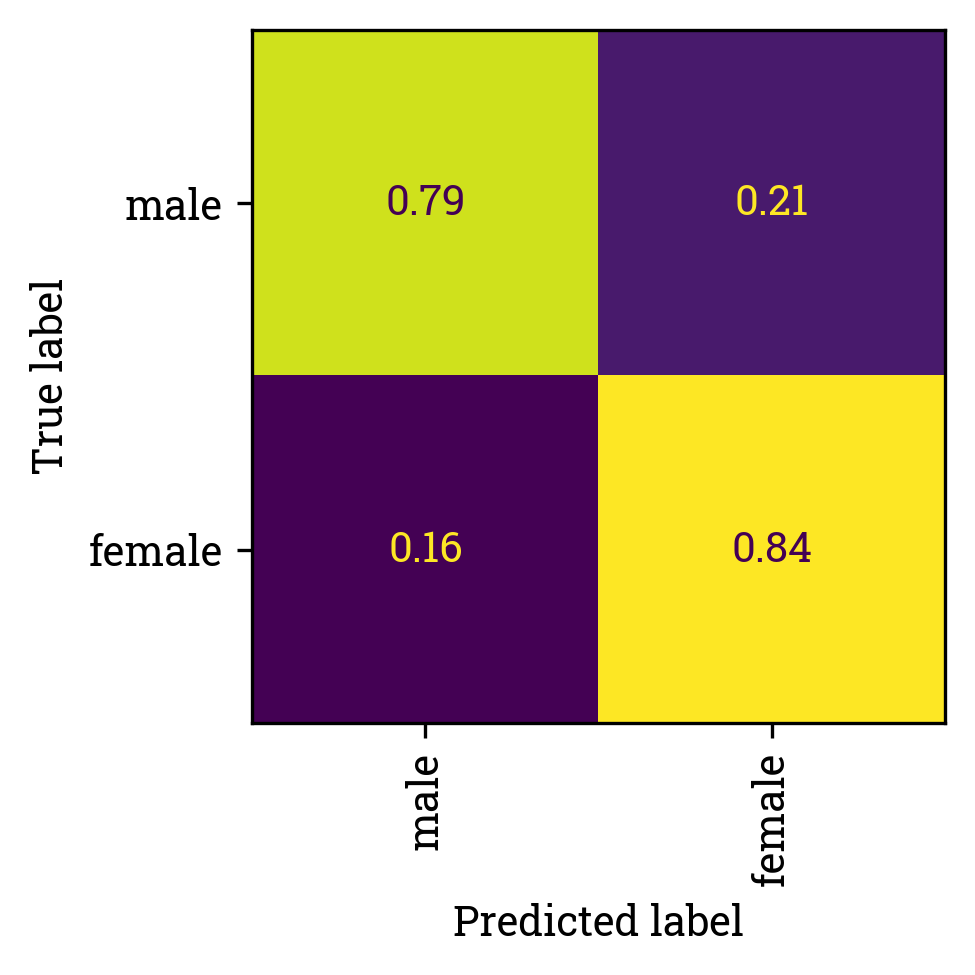

Squish 5: Macro F1-Score: 81.6%

Average Classification Report (25 splits with test size 0.1):
male                      precision 90.4%  recall 83.4%  f1-score 86.1%  support 13
female                    precision 88.6%  recall 92.5%  f1-score 90.2%  support 17
accuracy                  88.5%
macro avg_precision       89.5%
macro avg_recall          87.9%
macro avg_f1-score        88.1%
macro avg_support         30
weighted avg_precision    89.4%
weighted avg_recall       88.5%
weighted avg_f1-score     88.4%
weighted avg_support      30


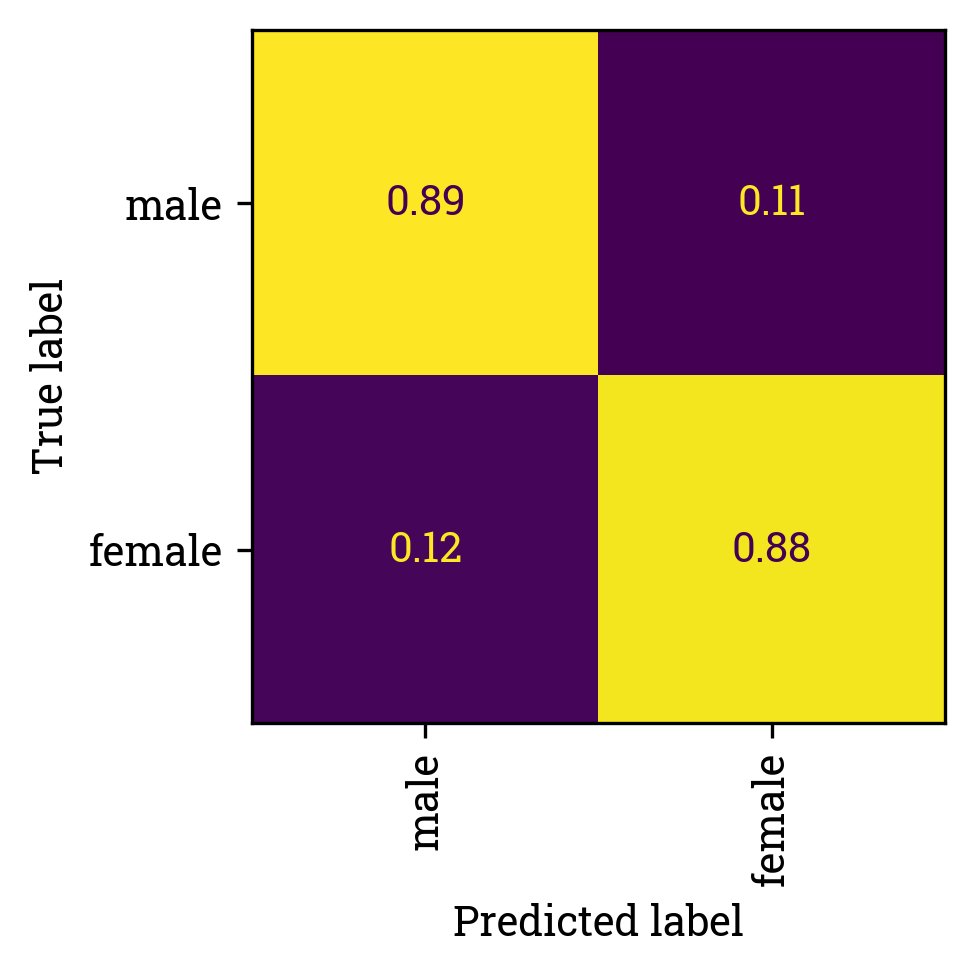

Squish 10: Macro F1-Score: 88.1%

Average Classification Report (25 splits with test size 0.1):
male                      precision 87.9%  recall 88.7%  f1-score 87.5%  support 6
female                    precision 93.0%  recall 91.1%  f1-score 91.7%  support 9
accuracy                  90.1%
macro avg_precision       90.4%
macro avg_recall          89.9%
macro avg_f1-score        89.6%
macro avg_support         15
weighted avg_precision    90.9%
weighted avg_recall       90.1%
weighted avg_f1-score     90.1%
weighted avg_support      15


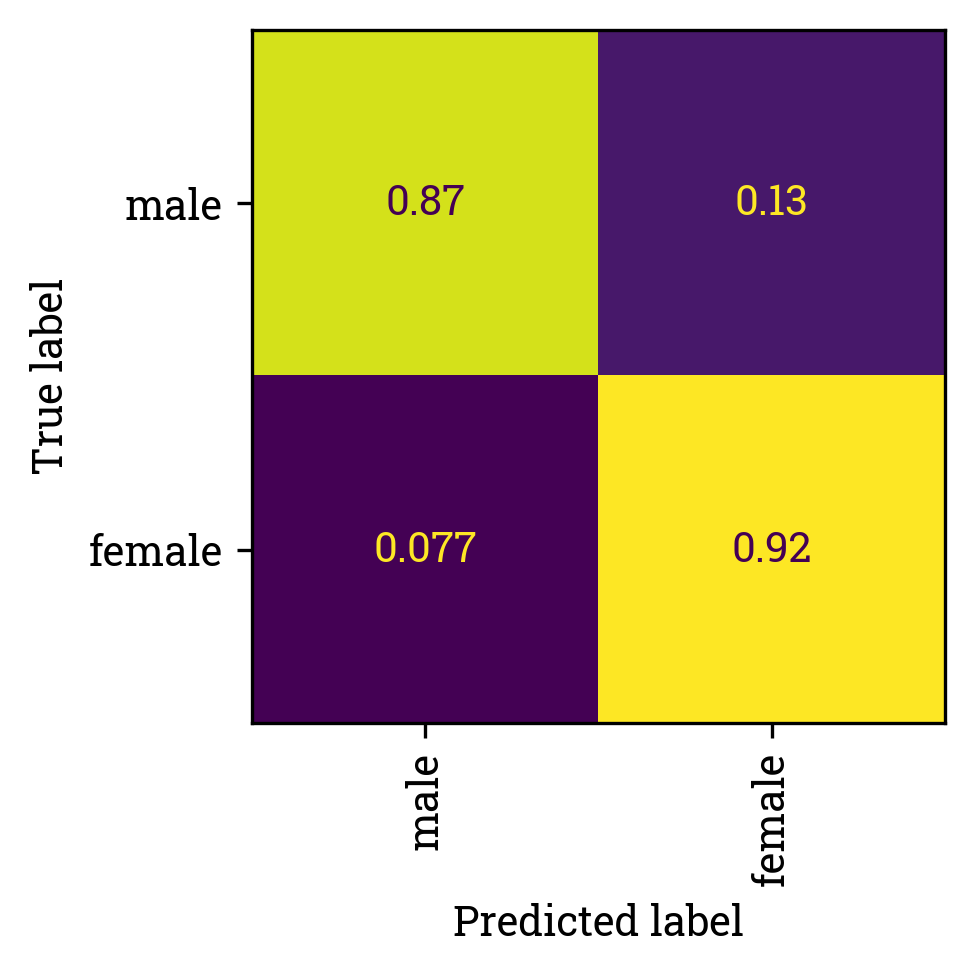

Squish 20: Macro F1-Score: 89.6%

Average Classification Report (25 splits with test size 0.1):
male                      precision 96.7%  recall 87.3%  f1-score 91.3%  support 6
female                    precision 90.7%  recall 97.1%  f1-score 93.5%  support 7
accuracy                  92.6%
macro avg_precision       93.7%
macro avg_recall          92.2%
macro avg_f1-score        92.4%
macro avg_support         13
weighted avg_precision    93.5%
weighted avg_recall       92.6%
weighted avg_f1-score     92.5%
weighted avg_support      13


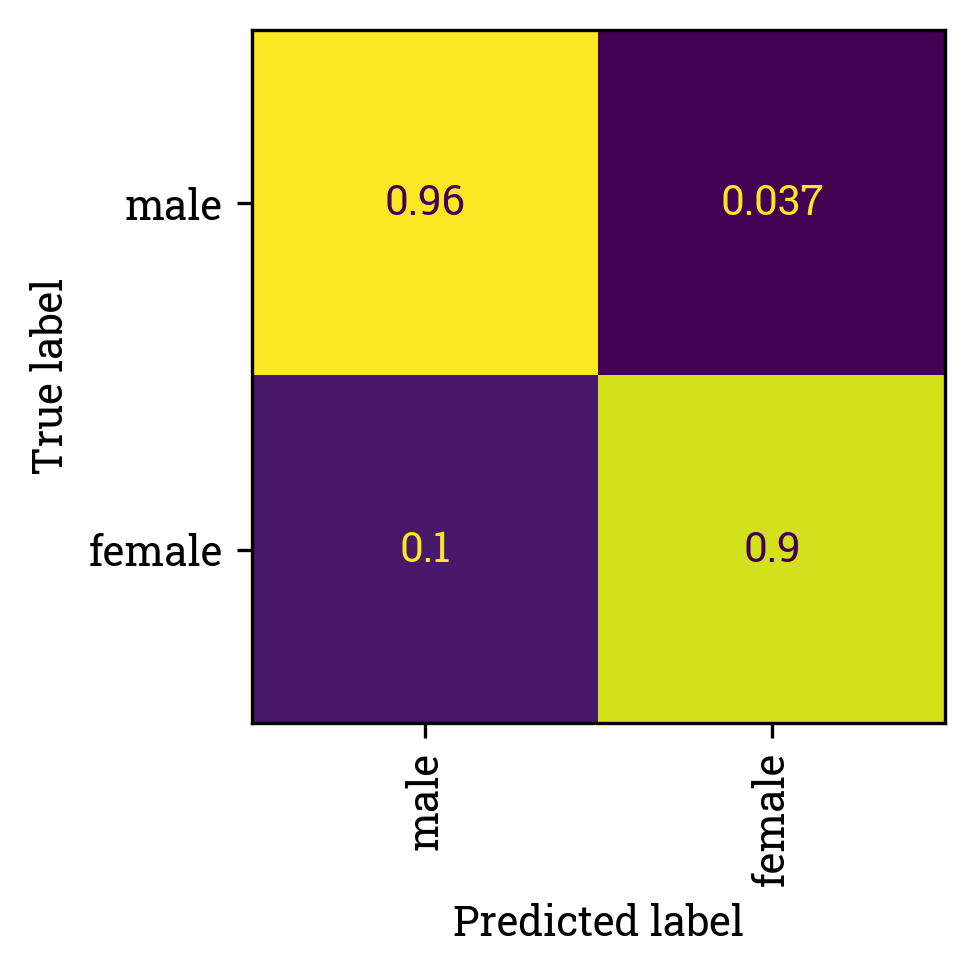

Squish 25: Macro F1-Score: 92.4%



In [33]:
masked_corpora = {}
for squish in [1, 2, 5, 10, 20, 25]:
    corpus = bench.vectorize_squish(
        train_df,
        fn=maskvec,
        groups=["title"],
        start_col=3,
        squish=squish,
        norm=True,
        scale=True,
    ).reset_index(drop=True)
    (_, X, y), report = bench.bench_and_fit(
        corpus.copy(), xgb, quiet=False, y_col="speaker", start_col=4
    )
    masked_corpora[squish] = {"corpus": corpus, "X": X, "y": y}
    print(f"Squish {squish}: Macro F1-Score: {report['macro avg_f1-score']:.1%}")
    print()

Test the trained models on the eval corpus

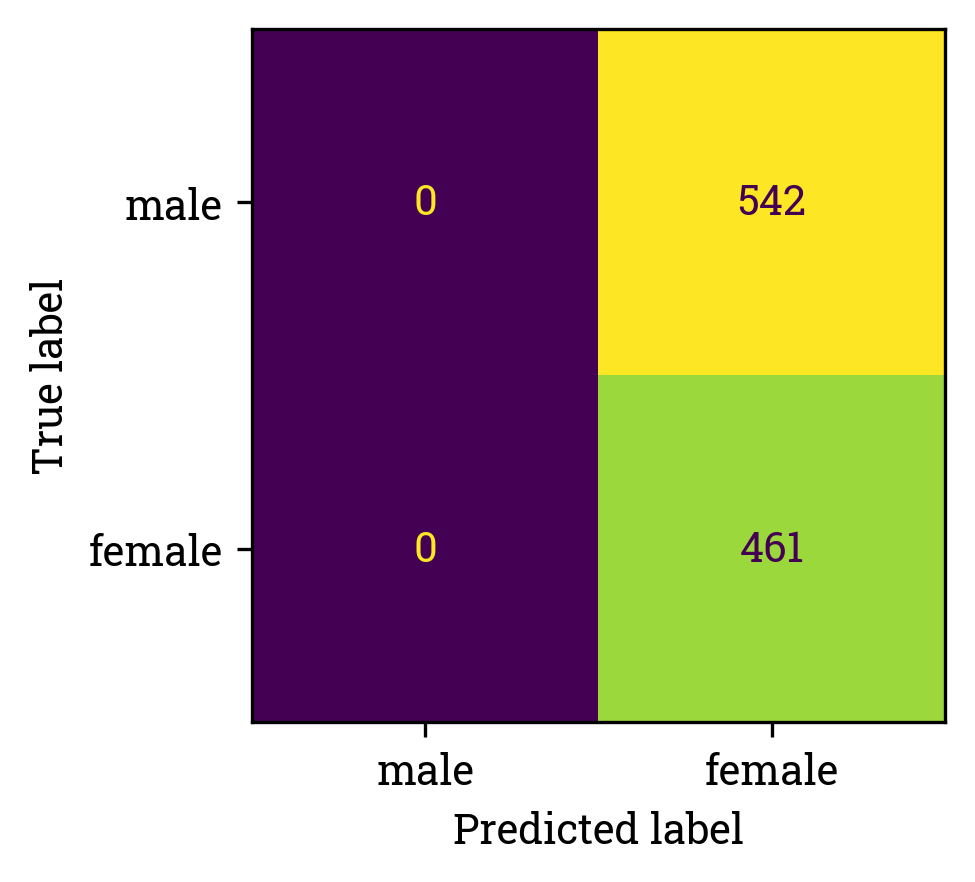

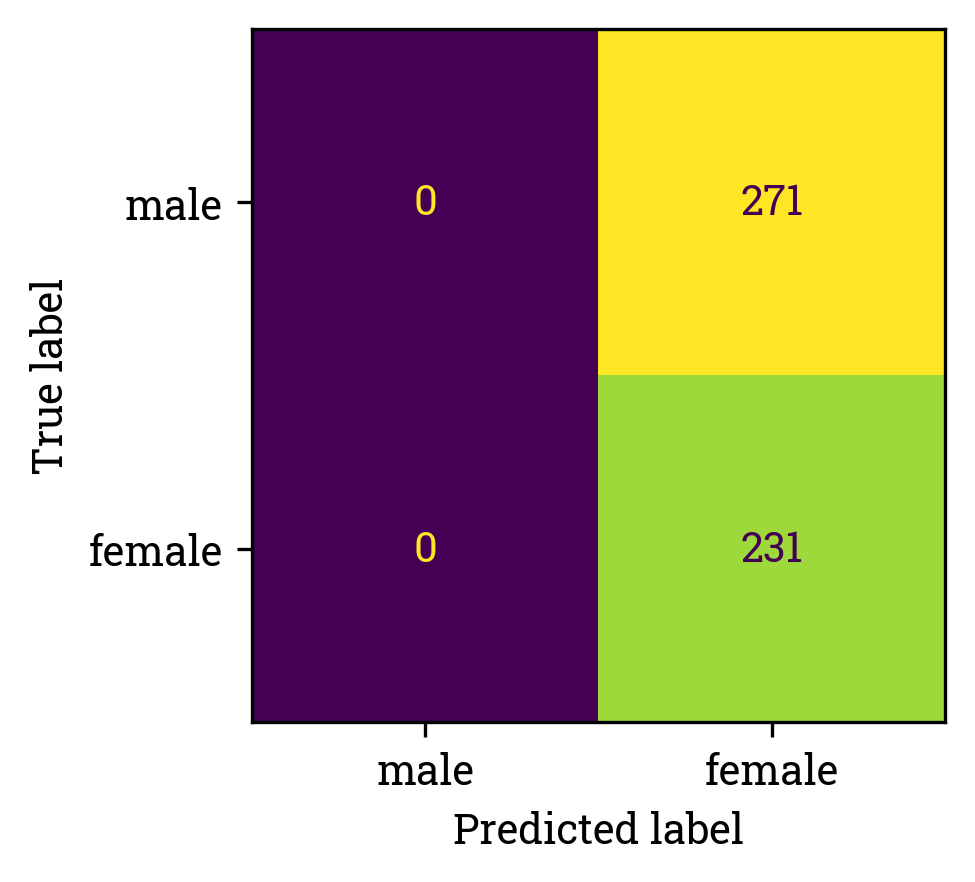

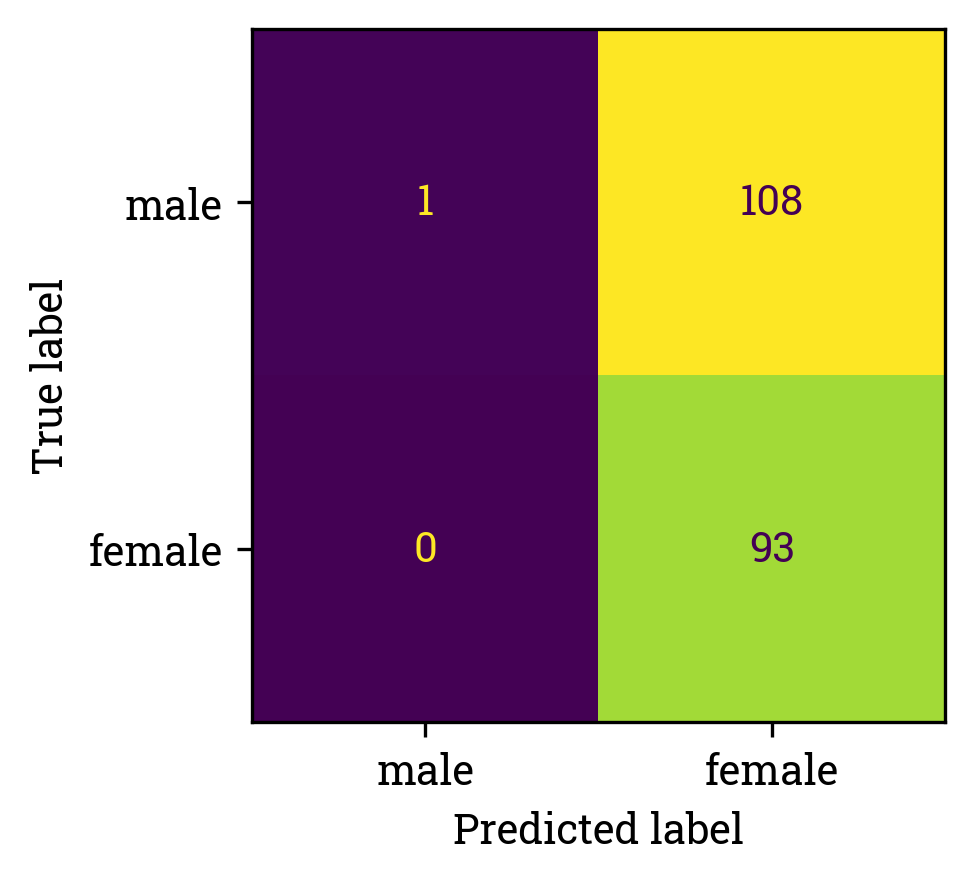

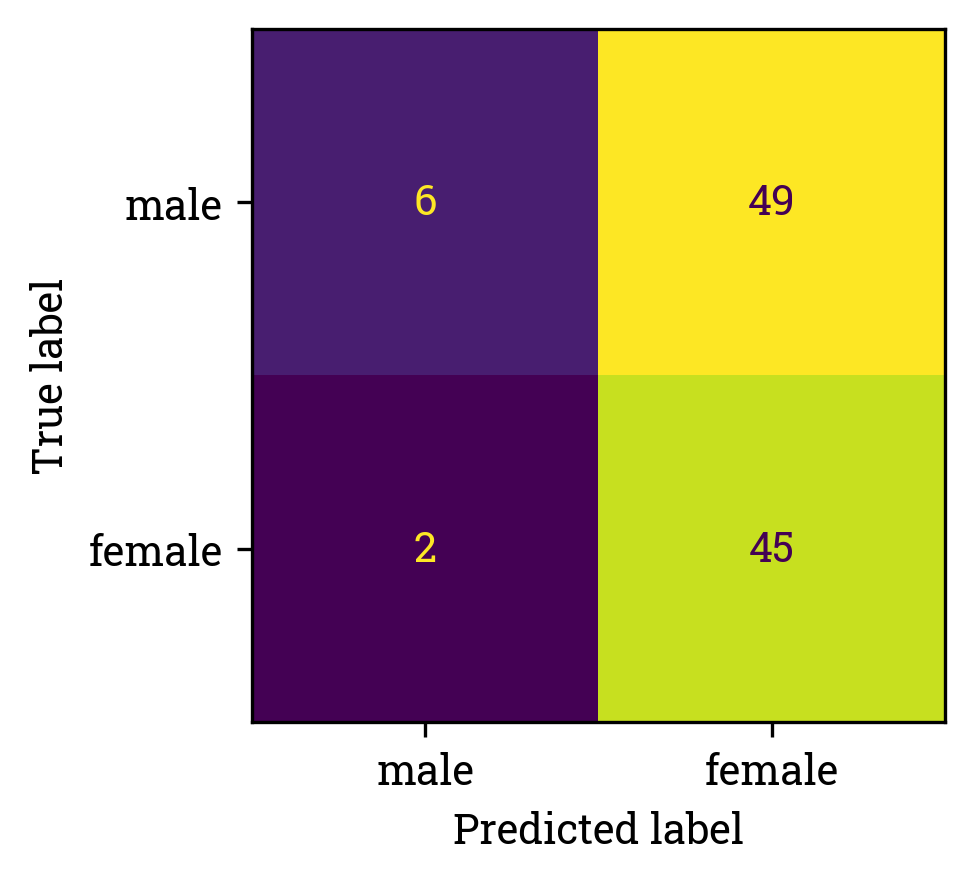

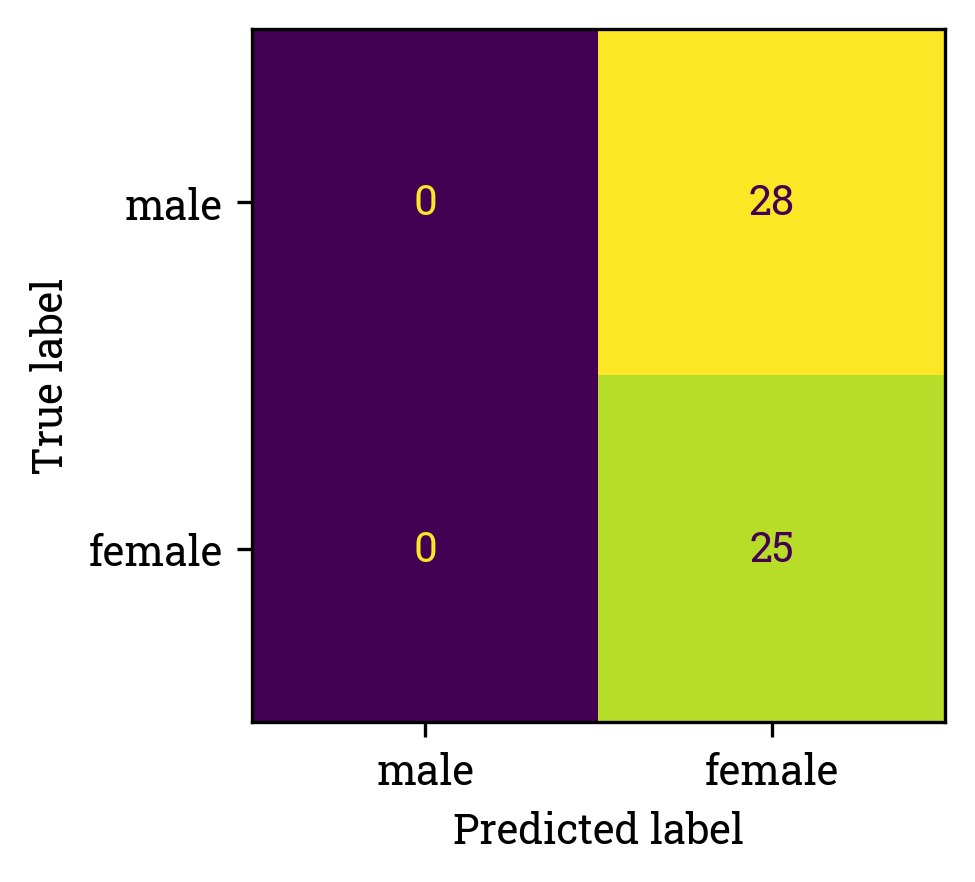

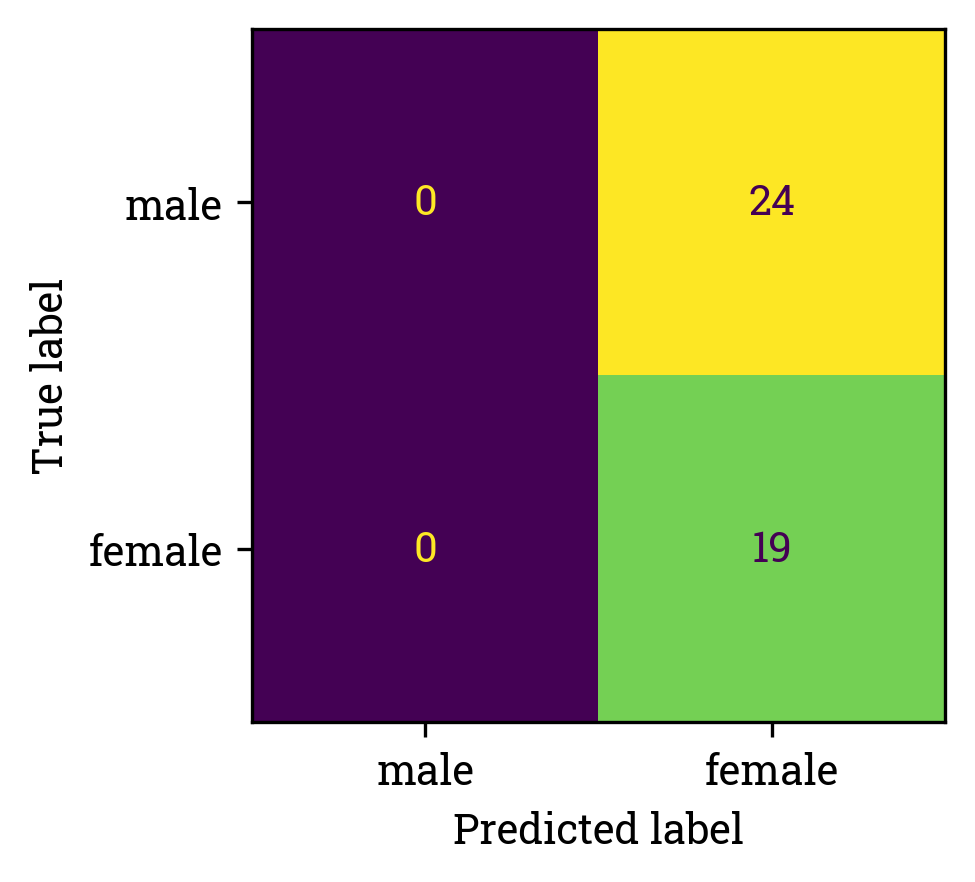

In [34]:
for squish in [1, 2, 5, 10, 20, 25]:
    # fit on saved training corpora
    model = xgb.fit(masked_corpora[squish]["X"], masked_corpora[squish]["y"])
    # squish the eval corpus to match
    eval_corpus = bench.vectorize_squish(
        eval_df,
        fn=maskvec,
        groups=["title"],
        start_col=3,
        squish=squish,
        norm=True,
        scale=False,
    ).reset_index(drop=True)
    X = eval_corpus.iloc[:, 4:]
    y, y_uniques = eval_corpus["speaker"].factorize()
    # eval on the eval corpus we just made
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(y_uniques),
    )
    disp.plot(colorbar=False)
    plt.show()

3. Distinctive syntactic features

5. lemma keyness

Average Classification Report (25 splits with test size 0.1):
male                      precision 66.3%  recall 59.1%  f1-score 62.4%  support 126
female                    precision 70.2%  recall 76.1%  f1-score 73.0%  support 159
accuracy                  68.6%
macro avg_precision       68.3%
macro avg_recall          67.6%
macro avg_f1-score        67.7%
macro avg_support         285
weighted avg_precision    68.5%
weighted avg_recall       68.6%
weighted avg_f1-score     68.3%
weighted avg_support      285


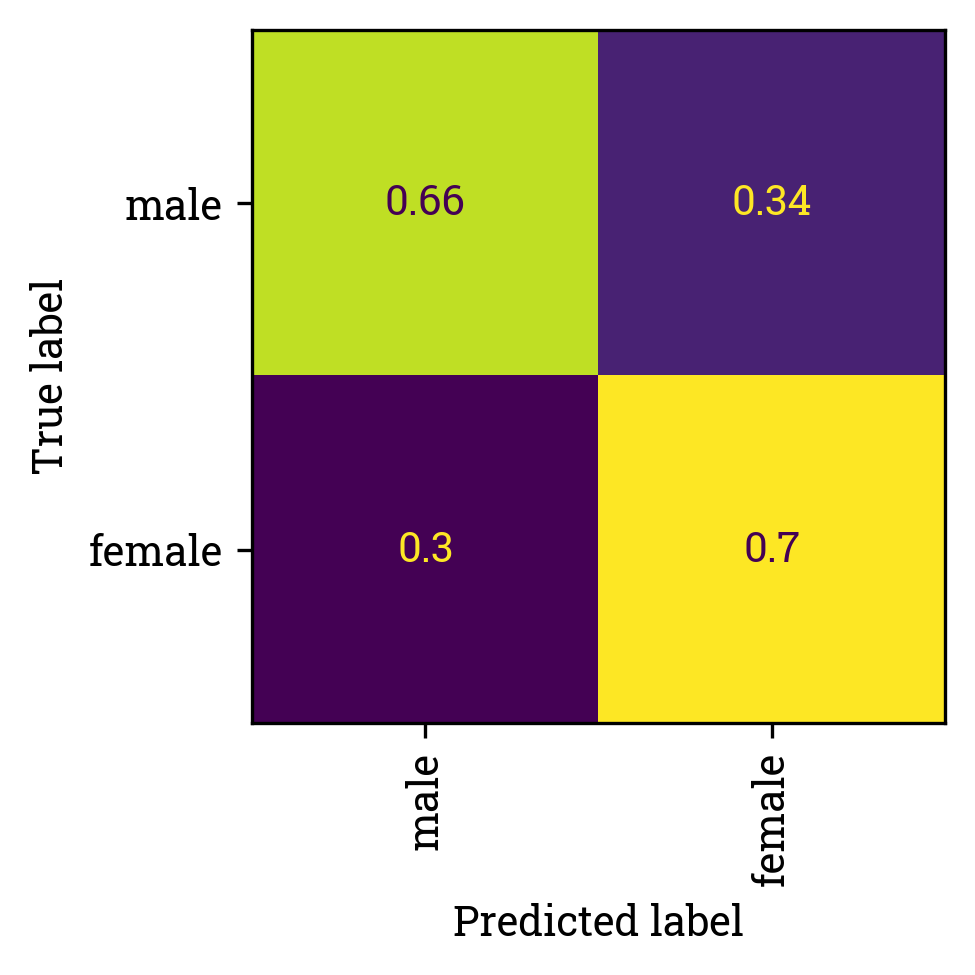

Squish 1: Macro F1-Score: 67.7%

Average Classification Report (25 splits with test size 0.1):
male                      precision 67.6%  recall 62.7%  f1-score 64.9%  support 63
female                    precision 72.3%  recall 76.2%  f1-score 74.1%  support 80
accuracy                  70.3%
macro avg_precision       69.9%
macro avg_recall          69.5%
macro avg_f1-score        69.5%
macro avg_support         143
weighted avg_precision    70.2%
weighted avg_recall       70.3%
weighted avg_f1-score     70.1%
weighted avg_support      143


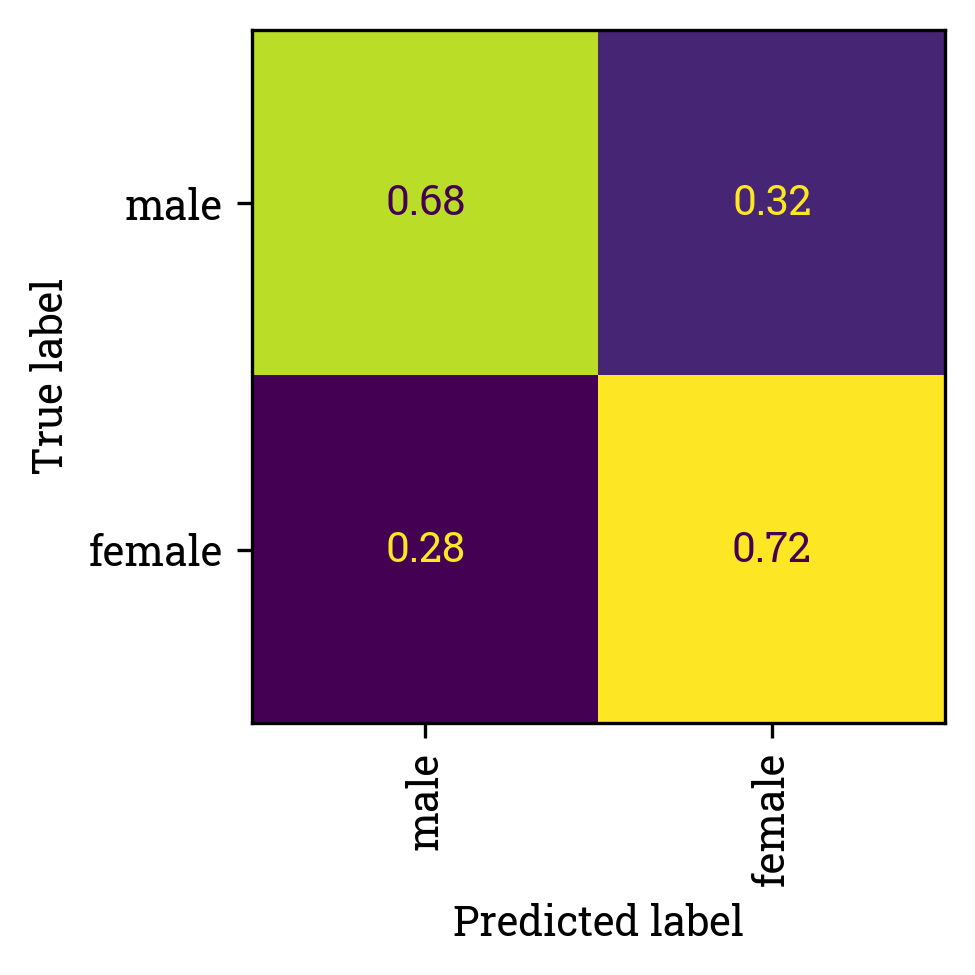

Squish 2: Macro F1-Score: 69.5%

Average Classification Report (25 splits with test size 0.1):
male                      precision 72.9%  recall 71.5%  f1-score 71.9%  support 25
female                    precision 78.9%  recall 79.5%  f1-score 79.0%  support 33
accuracy                  76.1%
macro avg_precision       75.9%
macro avg_recall          75.5%
macro avg_f1-score        75.5%
macro avg_support         58
weighted avg_precision    76.3%
weighted avg_recall       76.1%
weighted avg_f1-score     76.0%
weighted avg_support      58


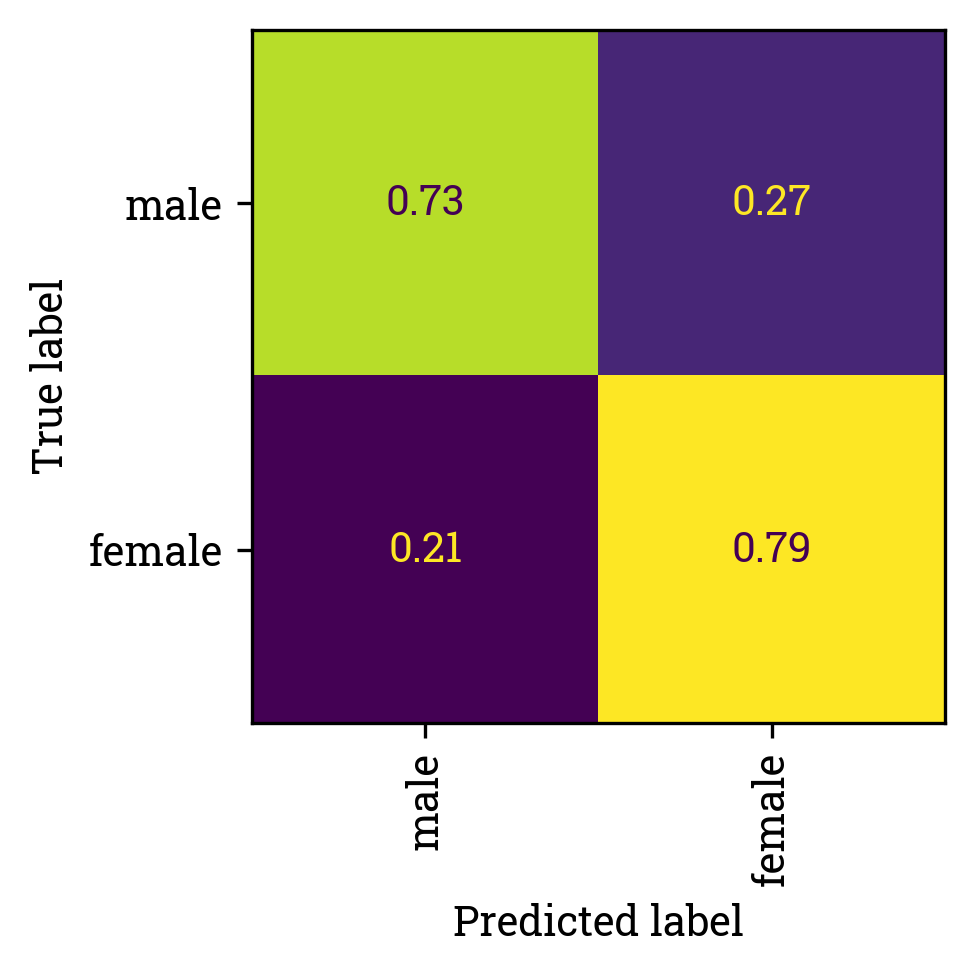

Squish 5: Macro F1-Score: 75.5%

Average Classification Report (25 splits with test size 0.1):
male                      precision 85.1%  recall 75.4%  f1-score 79.4%  support 13
female                    precision 82.6%  recall 88.7%  f1-score 85.3%  support 17
accuracy                  82.9%
macro avg_precision       83.8%
macro avg_recall          82.0%
macro avg_f1-score        82.4%
macro avg_support         30
weighted avg_precision    83.7%
weighted avg_recall       82.9%
weighted avg_f1-score     82.8%
weighted avg_support      30


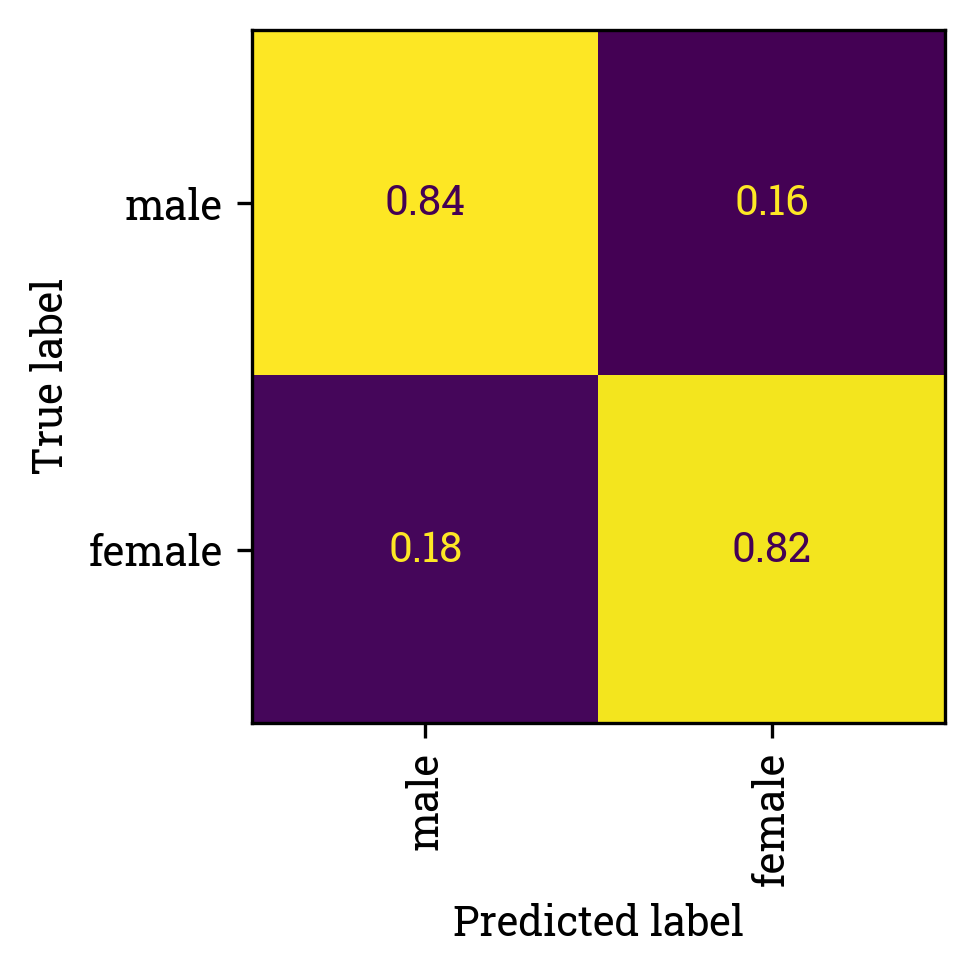

Squish 10: Macro F1-Score: 82.4%

Average Classification Report (25 splits with test size 0.1):
male                      precision 87.3%  recall 84.7%  f1-score 85.4%  support 6
female                    precision 90.1%  recall 90.7%  f1-score 90.1%  support 9
accuracy                  88.3%
macro avg_precision       88.7%
macro avg_recall          87.7%
macro avg_f1-score        87.7%
macro avg_support         15
weighted avg_precision    89.0%
weighted avg_recall       88.3%
weighted avg_f1-score     88.2%
weighted avg_support      15


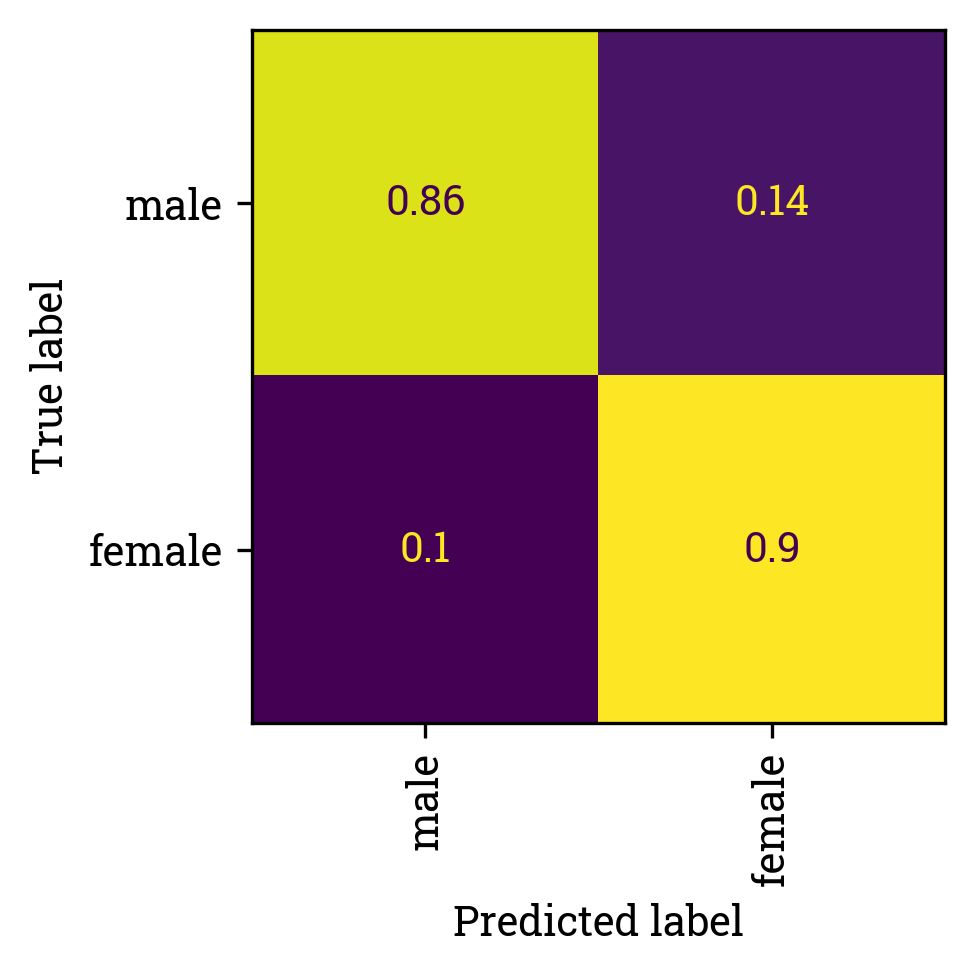

Squish 20: Macro F1-Score: 87.7%

Average Classification Report (25 splits with test size 0.1):
male                      precision 93.3%  recall 86.0%  f1-score 88.8%  support 6
female                    precision 89.7%  recall 94.3%  f1-score 91.6%  support 7
accuracy                  90.5%
macro avg_precision       91.5%
macro avg_recall          90.1%
macro avg_f1-score        90.2%
macro avg_support         13
weighted avg_precision    91.3%
weighted avg_recall       90.5%
weighted avg_f1-score     90.3%
weighted avg_support      13


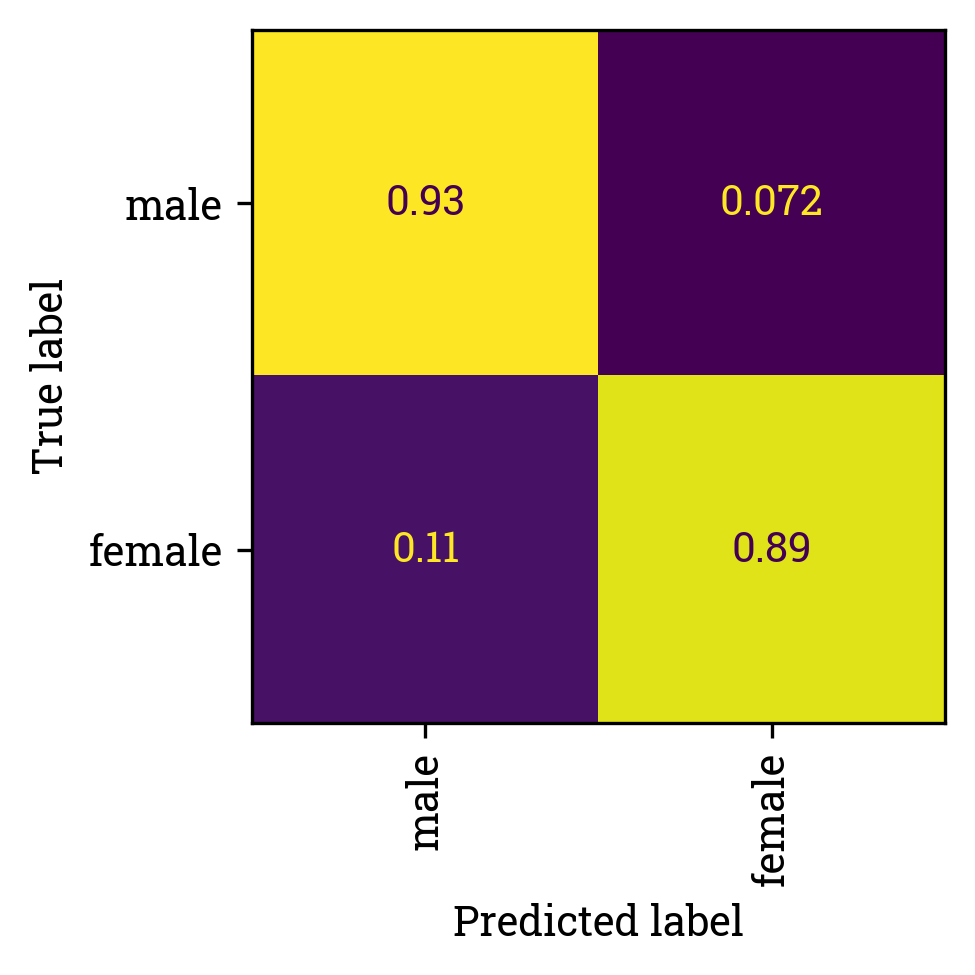

Squish 25: Macro F1-Score: 90.2%



In [35]:
lemma_corpora = {}
for squish in [1, 2, 5, 10, 20, 25]:
    corpus = bench.vectorize_squish(
        train_df,
        fn=lemmavec,
        groups=["title"],
        start_col=3,
        squish=squish,
        norm=True,
        scale=False,
    ).reset_index(drop=True)
    (model, X, y), report = bench.bench_and_fit(
        corpus.copy(), xgb, quiet=False, y_col="speaker", start_col=4
    )
    lemma_corpora[squish] = {"corpus": corpus, "model": clone(model), "X": X, "y": y}
    print(f"Squish {squish}: Macro F1-Score: {report['macro avg_f1-score']:.1%}")
    print()

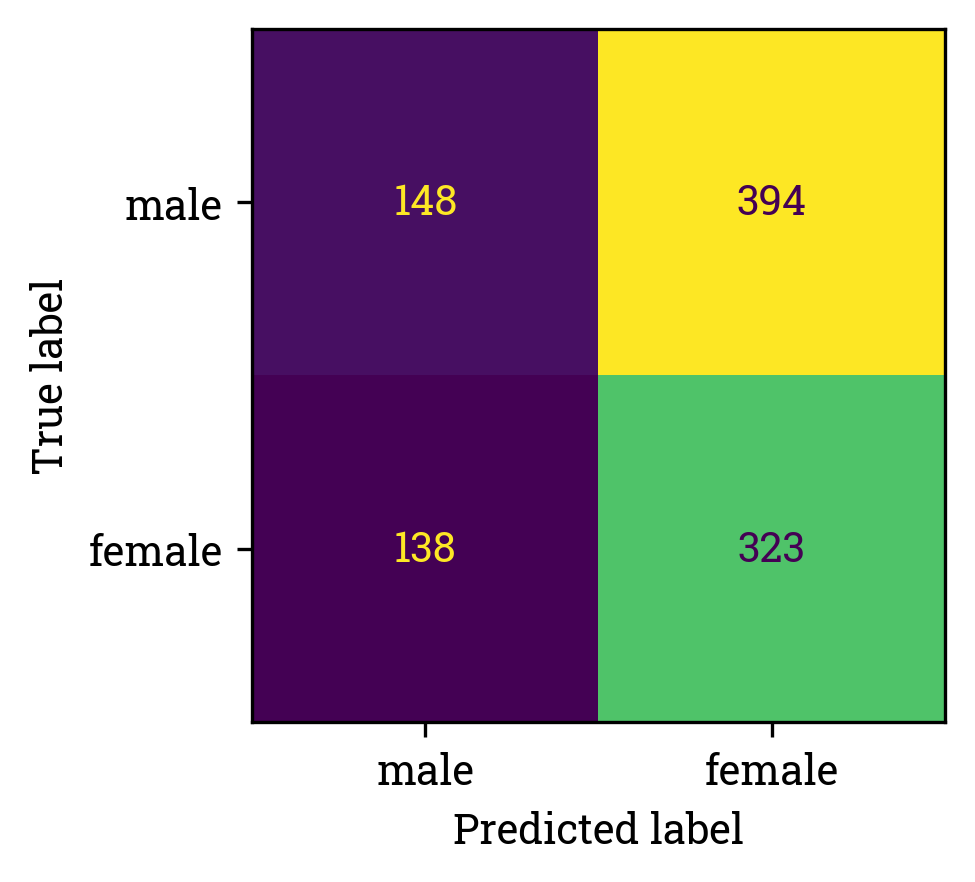

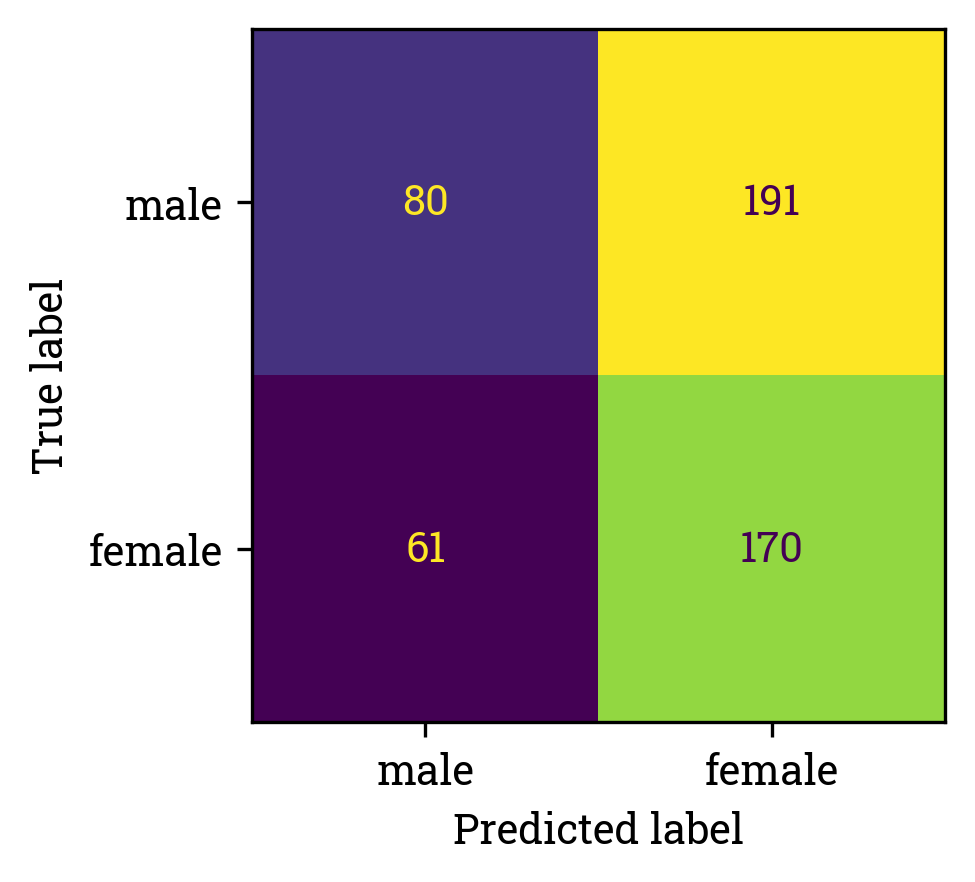

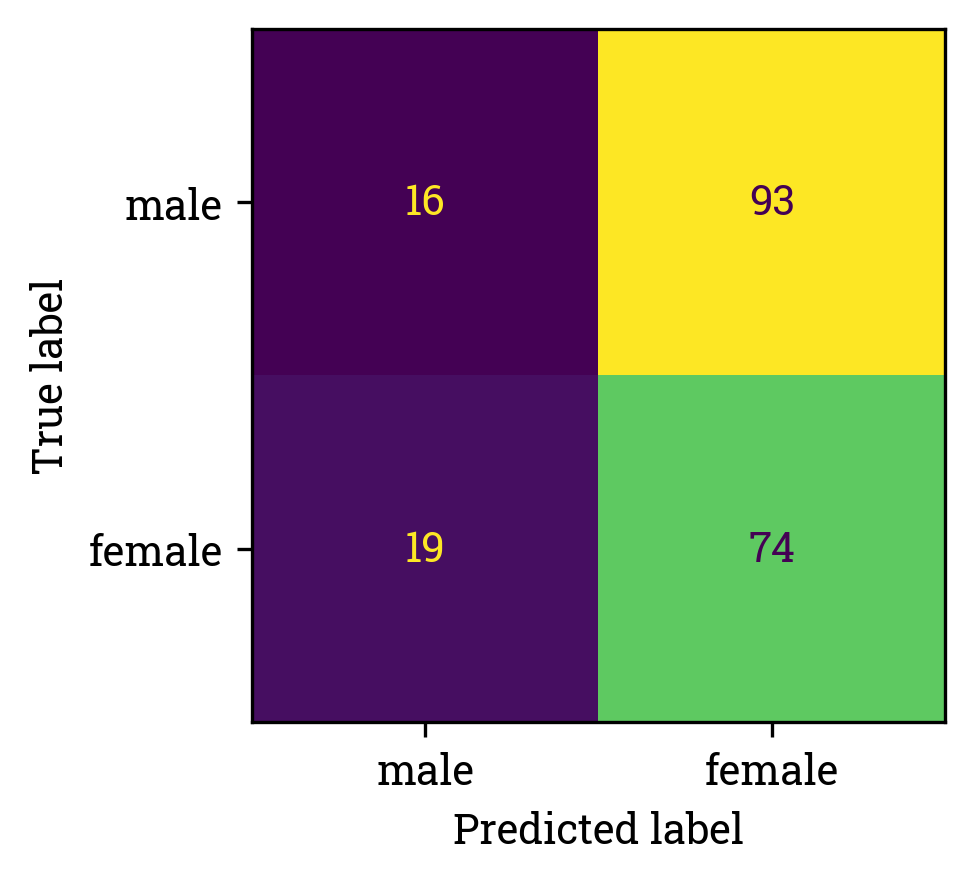

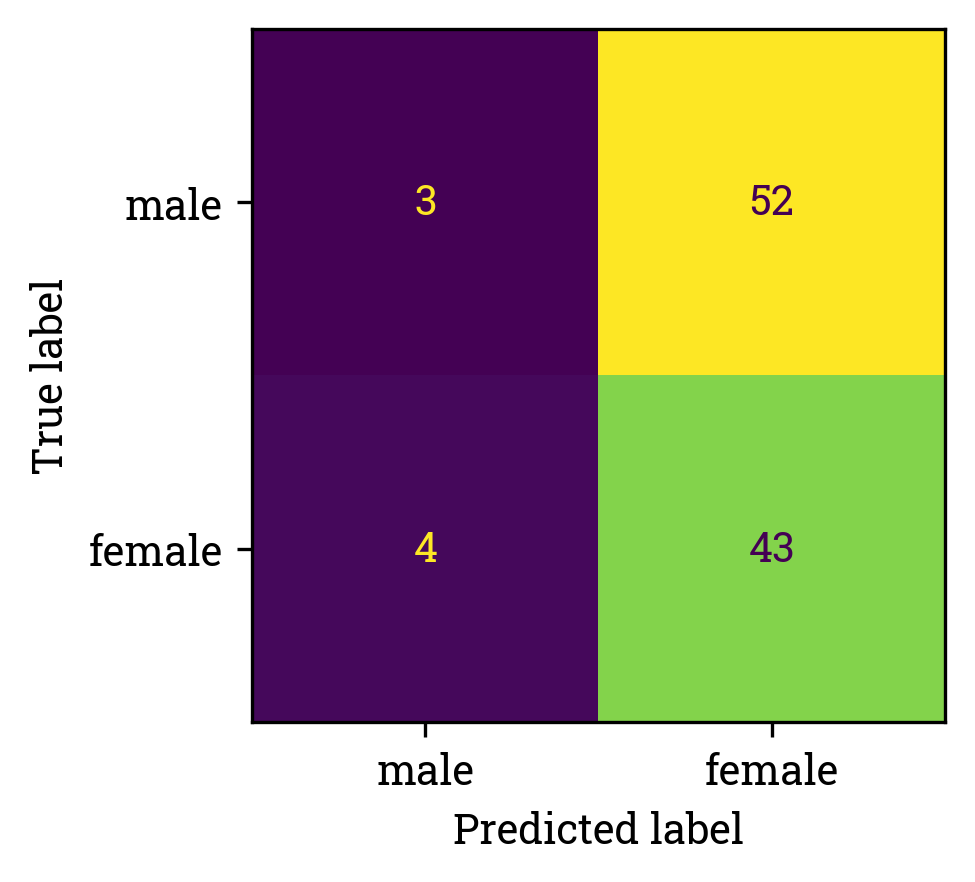

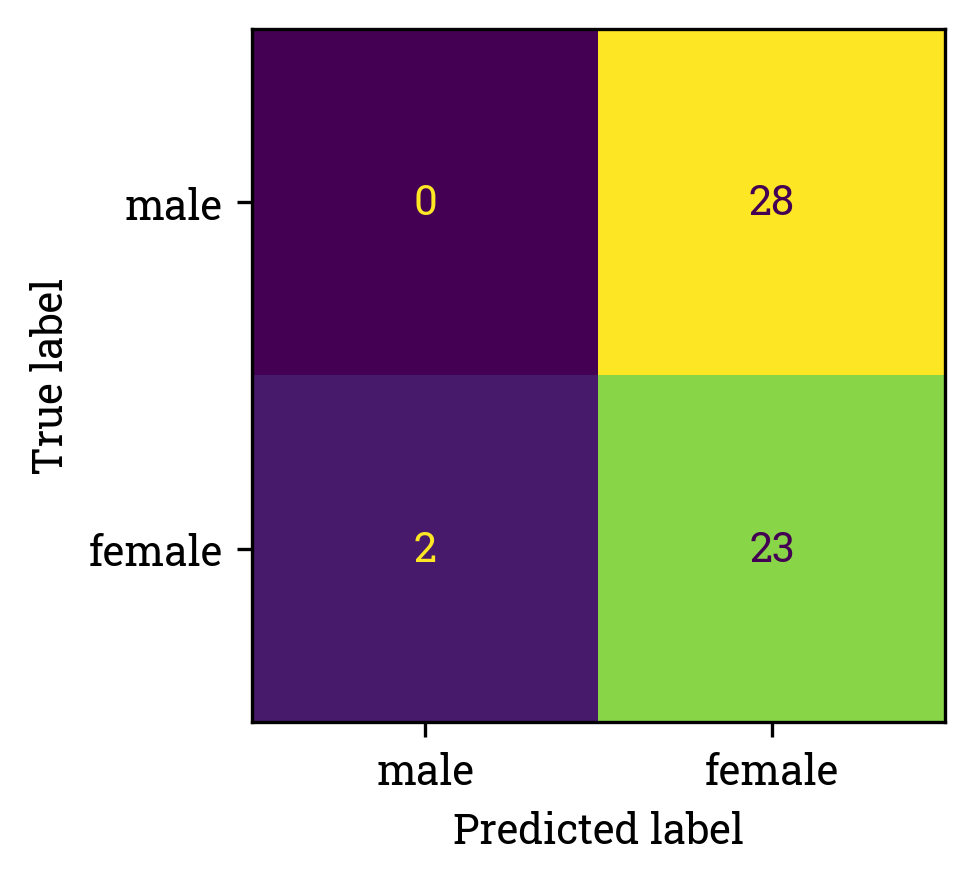

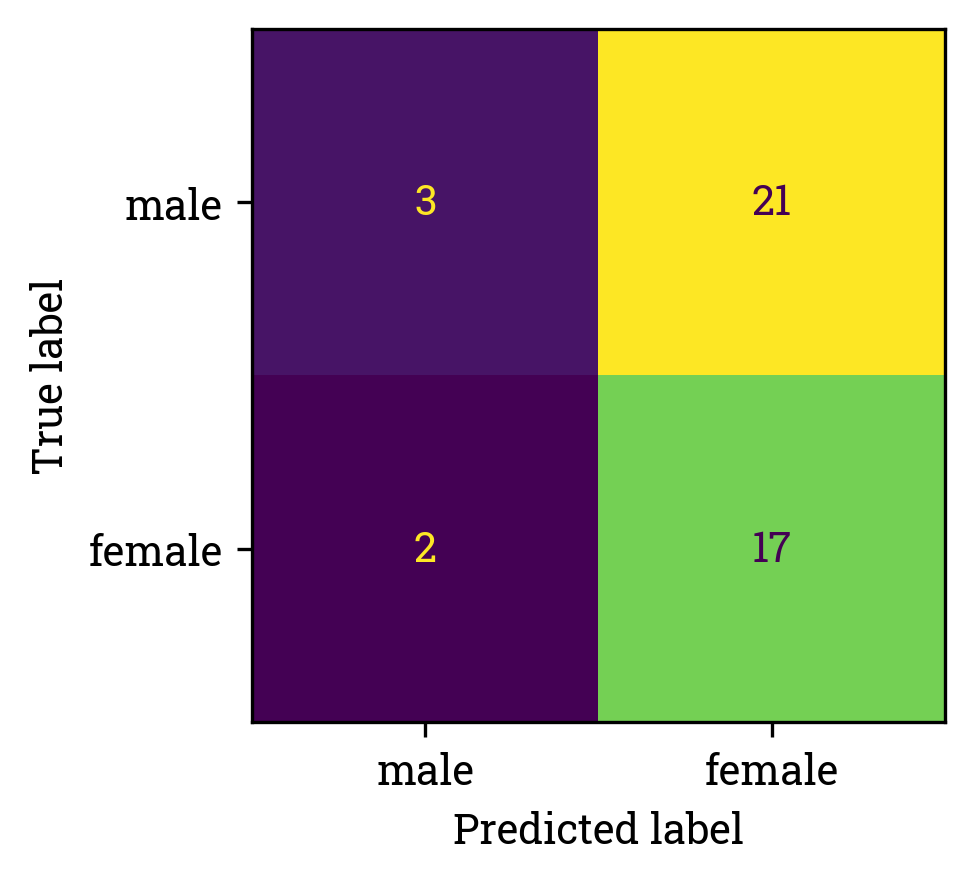

In [36]:
for squish in [1, 2, 5, 10, 20, 25]:
    # fit on saved training corpora
    model = xgb.fit(lemma_corpora[squish]["X"], lemma_corpora[squish]["y"])
    # squish the eval corpus to match
    eval_corpus = bench.vectorize_squish(
        eval_df,
        fn=lemmavec,
        groups=["title"],
        start_col=3,
        squish=squish,
        norm=True,
        scale=False,
    ).reset_index(drop=True)
    X = eval_corpus.iloc[:, 4:]
    y, y_uniques = eval_corpus["speaker"].factorize()
    # eval on the eval corpus we just made
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(y_uniques),
    )
    disp.plot(colorbar=False)
    plt.show()